## Introduction
This notebook contains the code to reproduce the figures in the paper: "Emergent Segmentation from Participation Dynamics and Multi-Learner Retraining"

In [91]:
%load_ext autoreload
%autoreload 2

from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import copy
from numpy.random.mtrand import beta
from sklearn.preprocessing import normalize

import folktables
from subpop import *
from learner_utils import *
from plot_utils import *

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Plotting settings
rc('text', usetex = False)
rc('font', family = 'serif')
context  = CONTEXT
sns.set_theme(style="whitegrid", font=FONT)

## Figure 4(a): [Synthetic] Risk dynamics over time.

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.5, 0.5]), array([0.5, 0.5]), array([0.5, 0.5])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


Final Conditions:
		Learners decisions: [[0.533 0.667]
 [0.533 0.667]]
		Subpopulation allocations: [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[1.  1. ]
 [0.3 0.5]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[0.  1. ]
 [0.8 0.5]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]

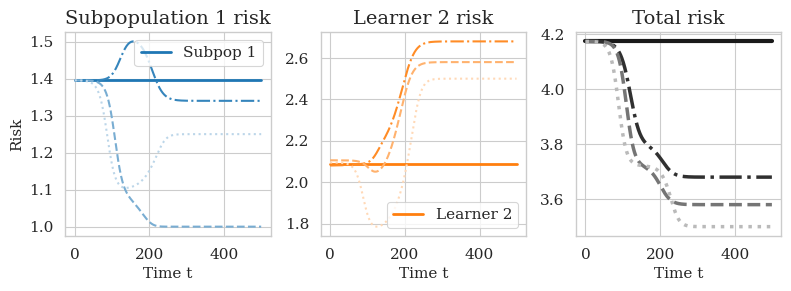

In [3]:
## -- Specify the optimal decisions for each subpopulation
phi_1 = np.array([0, 1])
phi_2 = np.array([1, 1])
phi_3 = np.array([0.6, 0])

##  -- Setup initial allocations of subpopulations to learners
allocations = [np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               ]  #<- select this to reproduce plots in the paper 

# allocations = [None]*4 #<- select this to run experiments  with new random initial conditions

## -- Select the type of risk minimization to be used by the learners
min_fn = quadratic_min #<- select this for noisy setting
# min_fn = quadratic_min #<- select this for noiseless updates from the learners 
# min_fn = gradient_step #<- select this for gradient descent updates from the learners

## -- Run the experiment and plot the results
T = 500 #<- number of rounds
legend_lst = [True, False, False, False] 
lw_lst = [2, 1.5, 1.5, 1.5]
ls_lst = ['-', '-.', '--', ':'] 
color_adj_lst = [1, 0.1, 0.4, 0.7,]       
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for trial in range(len(allocations)):
        alpha = allocations[trial]
        subpops = [QuadraticSubPop(phi_1, 1, alpha[:,0]), QuadraticSubPop(phi_2, 1, alpha[:,1]), QuadraticSubPop(phi_3, 1, alpha[:,2])]
        average_risks_subpop, average_risks_learner, all_risks, _, _ = run_experiment(T, subpops, min_fn=min_fn)
        ls = ls_lst[trial]
        lw = lw_lst[trial]
        color_adj = color_adj_lst[trial]
        legend = legend_lst[trial]
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, color_adj=color_adj, legend=legend, plot_learners=[1], plot_subpop = [0])
    plt.tight_layout()
    


## Figure 4(b): [Synthetic] Impact of competition on social welfare

In [14]:
##  -- Setup random seed for reproducing the results
seed = 0
rng = np.random.default_rng(0)

## -- Setup the experiment parameters
T = 1500  #<- number of rounds
n_subpops = 50 #<- number of subpopulations
n_learners_init = 2 #<- initial number of learners
n_learners_max = 20 #<- maximum number of learners
d = 8

## -- Initialize the subpopulations
phi = rng.normal(size=(n_subpops, d)) #<- optimal thetas for each subpop
alpha = np.ones(shape=(n_learners_init,n_subpops)) + rng.random(size=(n_learners_init,n_subpops))*0.0001
# alpha_ij <- fraction of subpop j going to learner i
alpha =  normalize(alpha, axis=0, norm='l1')
subpops = [QuadraticSubPop(phi[i,:], 1, alpha[:,i]) for i in range(n_subpops)]

## -- Run the experiment and plot the results
res = run_competition_experiment(T, subpops, n_learners_init=n_learners_init, n_learners_max=n_learners_max, min_fn=quadratic_min)

average_res= {k:np.mean(np.array(v), 1) for k, v in res.items()}
subpop_equilibrium_res = {k:v[-1] for k, v in res.items()}
average_equilibrium_res= {k:v[0] for k, v in average_res.items()}
break_times = {k:len(v) for k, v in average_res.items()}
break_times = np.cumsum(list(break_times.values()))

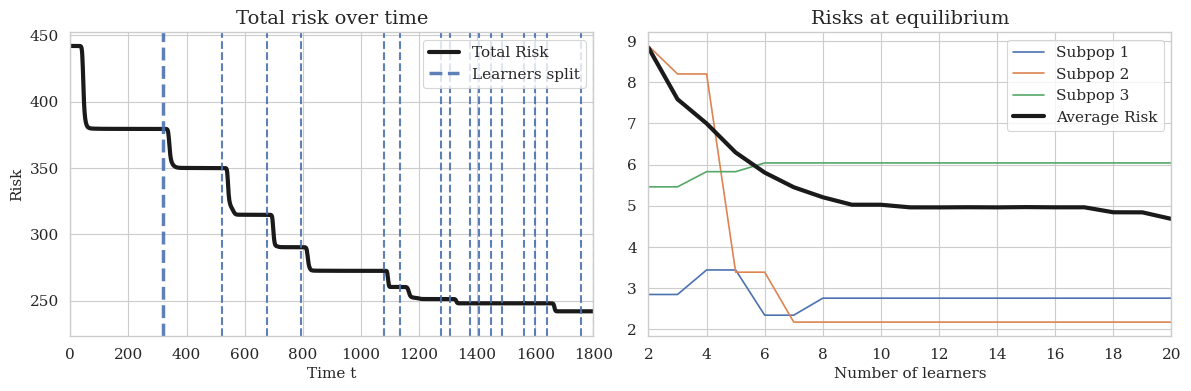

In [17]:
selected_subpops = range(3) #<- choose different subpopulations to plot the risk of alongside with total average risk.
with context:
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    axs[0].plot(n_subpops*np.concatenate((list(average_res.values()))), c='k', lw =3, label = 'Total Risk')
    for i, bt in enumerate(break_times):
        if i == 0:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 2.5, label='Learners split')
        else:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 1.5)
    axs[0].legend(loc = 1)
    axs[0].set_xlim([0, 1800])
    eq_risks = np.array(list(subpop_equilibrium_res.values()))
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), eq_risks[:,selected_subpops], label ='Subpop')
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), 
                list(average_equilibrium_res.values()), c='k', lw =3, label = 'Average Risk')
    axs[1].legend()
    axs[1].set_xlim([2, 20])
    axs[0].set_xlabel('Time t')
    axs[1].set_xlabel('Number of learners')
    axs[0].set_ylabel('Risk')
    axs[1].set_ylabel('')
    axs[0].set_title('Total risk over time')
    axs[1].set_title('Risks at equilibrium')
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h, ['Subpop 1', 'Subpop 2', 'Subpop 3', 'Average Risk'])
    plt.tight_layout()

## Figure 5(a): [Census] Risk dynamics over time.

In [92]:
features, label, group = generate_folktables_data()
# replade nas with zeros in a dataframe
features = features.fillna(0)

# convert dataframes to numpy arrays
features = np.nan_to_num(np.array(features),0)
label = np.nan_to_num(np.array(label),0).flatten()
group = np.nan_to_num(np.array(group),0).flatten()

In [93]:
# Generate allocations
n_subpops = len(np.unique(group))
n_learners = 3
allocation = 1+0.01*np.random.randn(n_subpops, n_learners)
allocation = normalize(allocation, axis=1, norm='l1') 

# Instantiate the subpopulations
subpops = []
for i,g in enumerate(np.unique(group)):
    g_inds = group==g
    g_beta = np.sum(g_inds) /len(group)
    print(f'Share of subpopulation {g}: {100*g_beta:.3f}%')
    subpops.append(EmpiricalSubPop(features[g_inds], label[g_inds], g_beta, allocation[i]))

Share of subpopulation 0: 61.714%
Share of subpopulation 1: 4.151%
Share of subpopulation 2: 0.637%
Share of subpopulation 3: 0.229%
Share of subpopulation 4: 17.113%
Share of subpopulation 5: 0.324%
Share of subpopulation 6: 11.769%
Share of subpopulation 7: 4.062%


In [95]:
# Run the retention dynamics
T=10000
min_fn = quadratic_min
verbose = True
average_risks_subpop, average_risks_learner, all_risks, _, _ = run_experiment(T, subpops, min_fn=min_fn, verbose=verbose)

Initial Conditions:
There are 3 initial learners
Subpopulation splits: [0.6171423933962483, 0.041505321492336586, 0.006370719039117027, 0.002289748881211306, 0.17113409233194982, 0.0032404294293597977, 0.11769309249426113, 0.04062420293551603]
Initial allocations: [array([0.332, 0.333, 0.335]), array([0.337, 0.336, 0.327]), array([0.333, 0.329, 0.339]), array([0.331, 0.333, 0.336]), array([0.327, 0.337, 0.336]), array([0.333, 0.334, 0.333]), array([0.336, 0.331, 0.333]), array([0.339, 0.328, 0.333])]
Optimal decisions theta for each subpop (row-wise) [array([ 11.399,   2.748,  -0.366,  11.017,   1.369,   5.798,   6.95 ,
         6.369,   7.375,  -5.239, -31.364,   1.922,  -0.227,   1.644]), array([ 13.731,   2.898,   0.373,   8.301,   0.656,   4.717,  10.986,
        10.509,   7.698,  -4.383, -31.986,   2.767,  -0.255,   1.249]), array([ 13.141,   2.477,   0.498,   8.662,   1.818,   6.727,   5.769,
         5.986,   9.345,  -2.176, -30.142,   3.467,  -0.298,   3.204]), array([ 13.143, 

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

### Risk of subpopulation and learnears over time

In [ ]:
# compute relative risk for subpopulations
best_risks = []
betas = []
for i in range(len(subpops)):
    best_risks.append(subpops[i].risk(subpops[i].phi))
    betas.append(subpops[i].beta)

relative_risks_subpop = []
for i in range(len(average_risks_subpop)):
    relative_risks_subpop.append(100*((average_risks_subpop[i]/betas)/(best_risks) - 1))

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (13,4), gridspec_kw={'width_ratios':[1,0.8, 0.5], 'wspace': 0.1})
plot_experiment(relative_risks_subpop, average_risks_learner, all_risks, axs,
               plot_learners=3, plot_subpop=8)
for i,ax in enumerate(axs):
    ax.set_xlim(0,25)
    ax.tick_params(axis='y', which='major', pad=-4)
    ax.set_ylabel('')
    if i <= 1:
        ax.legend()
    if i == 0:
        #ax.set_ylabel('Relative Risk (%)')
        ax.set_title('Relative Subpopulation risks over time (%)')
    if i== 2:
        ax.set_yticks([])
        ax.set_ylabel('')
fig.savefig('census_loss.pdf')

### Ternary plot of allocation dynamics

In [ ]:
df_full = pd.DataFrame(columns = ['Learner 1', 'Learner 2', 'Learner 3', 'Subpopulation', 'Step'])
for i in range(len(all_alphas)):
    df = pd.DataFrame(all_alphas[i].T, columns = ['Learner 1', 'Learner 2', 'Learner 3'])
    df['Subpopulation'] = range(8)
    df['Step'] = i
    df_full = pd.concat([df_full, df])
df_full['Size'] = 0.1

In [ ]:
fig = px.scatter_ternary(df_full, size_max = 5, opacity = 0.8,
                         a="Learner 1", b="Learner 2", c="Learner 3", color = "Subpopulation")
fig.show()

In [ ]:
def run_trial(allocation=None, min_fn = quadratic_min, sample_size = None, k = 100000, T=500, temp=0.1, shared_sample = True):
    # relative sizes
    beta_1 = 1
    beta_2 = 1 
    beta_3 = 1
    # initial allocations
    if allocation is  None:
        dist = np.random.rand(2,3)*0.1
        alpha = np.array([[1,1, 1], [1,1, 1]]) + dist
        # alpha_ij <- fraction of subpop j going to learner i
        alpha =  normalize(alpha, axis=0, norm='l1')   
    else:
        alpha = allocation
    # optimal thetas for each subpop
    phi_1 = np.array([0, 1])
    phi_2 = np.array([1, 1])
    phi_3 = np.array([0.6, 0])
    # phi = np.array([phi_1, phi_2])
    
    
    if k is None:
        pop1 = QuadraticSubPop(phi_1, beta_1, alpha[:,0])
        pop2 = QuadraticSubPop(phi_2, beta_2, alpha[:,1])
        pop3 = QuadraticSubPop(phi_3, beta_3, alpha[:,2])
    
    else:
        pop1_xs = np.random.normal(size=(k, 2))
        pop1_ys = pop1_xs@phi_1 + np.random.normal(size=k)*1
        
        pop2_xs = np.random.normal(size=(k, 2))
        pop2_ys = pop2_xs@phi_2 + np.random.normal(size=k)*1
        
        pop3_xs = np.random.normal(size=(k, 2))
        pop3_ys = pop3_xs@phi_3 + np.random.normal(size=k)*1
        
        if shared_sample:
            pop1 = SampledSubPop(pop1_xs, pop1_ys, beta_1, alpha[:,0])
            pop2 = SampledSubPop(pop2_xs, pop2_ys, beta_2, alpha[:,1])
            pop3 = SampledSubPop(pop3_xs, pop3_ys, beta_3, alpha[:,2])
        else:
            pop1 = SampledMultinomialSubPop(pop1_xs, pop1_ys, beta_1, alpha[:,0])
            pop2 = SampledMultinomialSubPop(pop2_xs, pop2_ys, beta_2, alpha[:,1])
            pop3 = SampledMultinomialSubPop(pop3_xs, pop3_ys, beta_3, alpha[:,2])
    
    subpops = [pop1, pop2, pop3]

    # Run dynamics and create plots
    (average_risks_subpop, average_risks_learner, all_risks, _, all_alphas) = run_experiment(T, subpops, min_fn=min_fn, rr=False, sample_size = sample_size, temp=temp)
    
    return(average_risks_subpop, average_risks_learner, all_risks, all_alphas)